# GRIP @ The Sparks Foundation
Author : Arjun dey¶
Task 7 : Stock Market Prediction using Numerical and Textual Analysis
In this task, I have tried to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

Technical Stack : Sikit Learn, Numpy Array, Pandas, Matplotlib, Keras, NLTK, Textblob, Xgboost


# 1 - Import the required Libraries¶


In [59]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [60]:
# !pip install pandas_datareader

In [61]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [62]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [63]:
print('Showing dataset:')
ndf.head(5)

Showing dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [64]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
1048566,20110123,FMS wins Manfest Yajna; IIM-L finishes third
1048567,20110123,Tanks; combat vehicles part of Republic Day pa...
1048568,20110123,Restrictions on traffic movement in city
1048569,20110123,Mobile cos; cops for postal delivery of SIM


In [65]:
# Loading the second dataset

hisdf = pd.read_csv("BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-12-2019,41052.35938,41401.64844,41005.17969,41352.17188,41352.17188,19000.0
1,18-12-2019,41442.75000,41614.76953,41358.46875,41558.57031,41558.57031,24300.0
2,19-12-2019,41571.82031,41719.28906,41456.39844,41673.92188,41673.92188,33300.0
3,20-12-2019,41746.19922,41809.96094,41636.10938,41681.53906,41681.53906,33600.0
4,23-12-2019,41548.26172,41701.62109,41474.60938,41642.66016,41642.66016,6200.0
...,...,...,...,...,...,...,...
242,04-12-2020,44665.91016,45148.28125,44665.91016,45079.55078,45079.55078,27600.0
243,07-12-2020,45099.92188,45458.92188,45024.46875,45426.96875,45426.96875,18700.0
244,08-12-2020,45568.80078,45742.23047,45335.17188,45608.51172,45608.51172,18200.0
245,09-12-2020,45891.03906,46164.10156,45792.01172,46103.50000,46103.50000,20700.0


# 2 - Common Dataset Exploration¶


In [66]:
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 1 to 1048575
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1048575 non-null  datetime64[ns]
 1   News    1048575 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 24.0+ MB


In [67]:
# Group the headlines for each day

ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [68]:
ndf


,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
3627,2011-01-19,My ex doesn't want me: Pratik Saali is not a g...
3628,2011-01-20,Neetu Chandra denies going panty-less! Aishwar...
3629,2011-01-21,Giving the kids a dressing up AK Hangal's ill ...
3630,2011-01-22,DTE seeks report from tech institutes Corporat...


In [69]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [70]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,17-12-2019,41052.35938,41401.64844,41005.17969,41352.17188,19000.0
1,18-12-2019,41442.75000,41614.76953,41358.46875,41558.57031,24300.0
2,19-12-2019,41571.82031,41719.28906,41456.39844,41673.92188,33300.0
3,20-12-2019,41746.19922,41809.96094,41636.10938,41681.53906,33600.0
4,23-12-2019,41548.26172,41701.62109,41474.60938,41642.66016,6200.0
...,...,...,...,...,...,...
242,04-12-2020,44665.91016,45148.28125,44665.91016,45079.55078,27600.0
243,07-12-2020,45099.92188,45458.92188,45024.46875,45426.96875,18700.0
244,08-12-2020,45568.80078,45742.23047,45335.17188,45608.51172,18200.0
245,09-12-2020,45891.03906,46164.10156,45792.01172,46103.50000,20700.0


In [71]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [72]:
hisdf.describe()


,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237376,38071.182860,37422.826993,37745.454118,19134.000000
std,4507.985770,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810550,27462.869140,25638.900390,25981.240230,0.000000
25%,34369.659182,34779.932618,33975.389648,34257.097655,13125.000000
50%,38489.480470,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222660,41376.482420,41023.923832,41135.233398,21075.000000
max,46774.320310,46992.570310,46627.601560,46890.339840,188300.000000


In [73]:
# Check for duplicated values
hisdf.isnull().sum()


Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

Text(0, 0.5, 'BSESN')

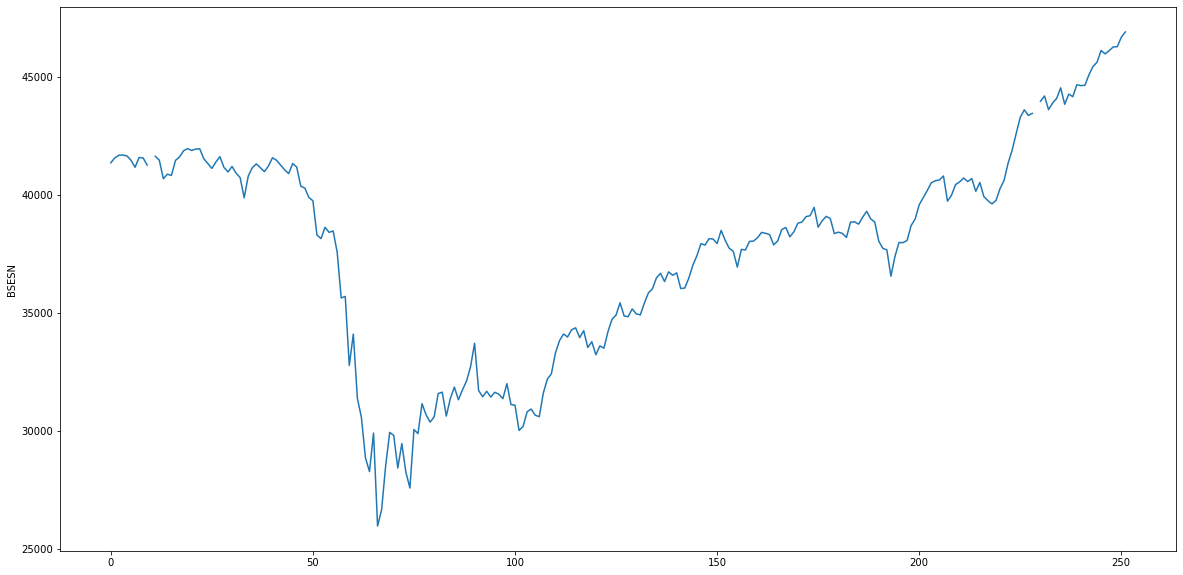

In [74]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

# Remove Unwanted Characters from the News¶


In [75]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# 3 - Historical Analysis¶


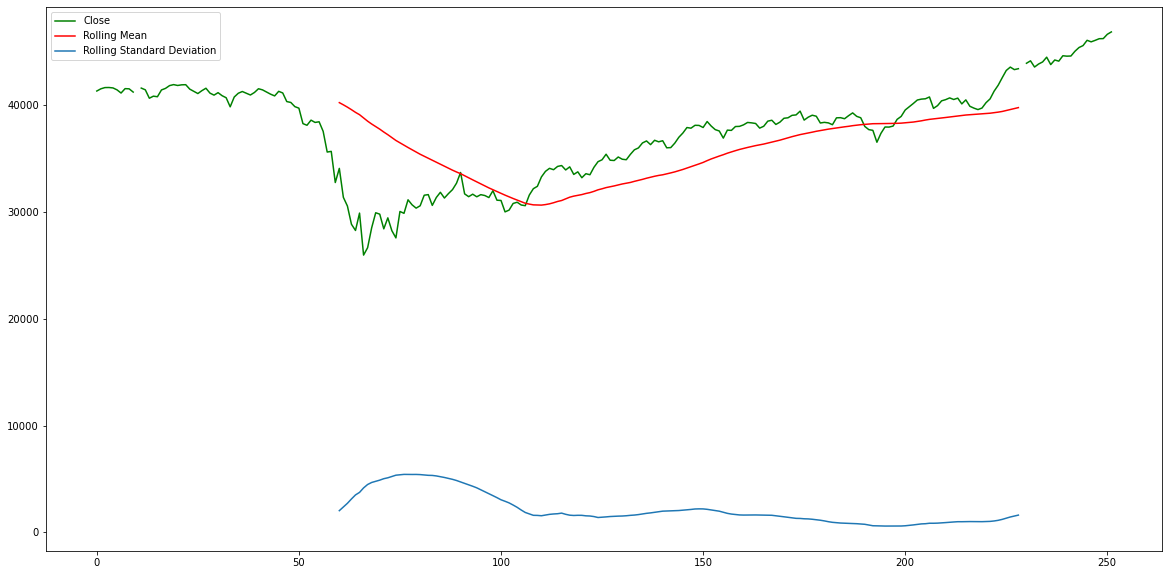

In [76]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

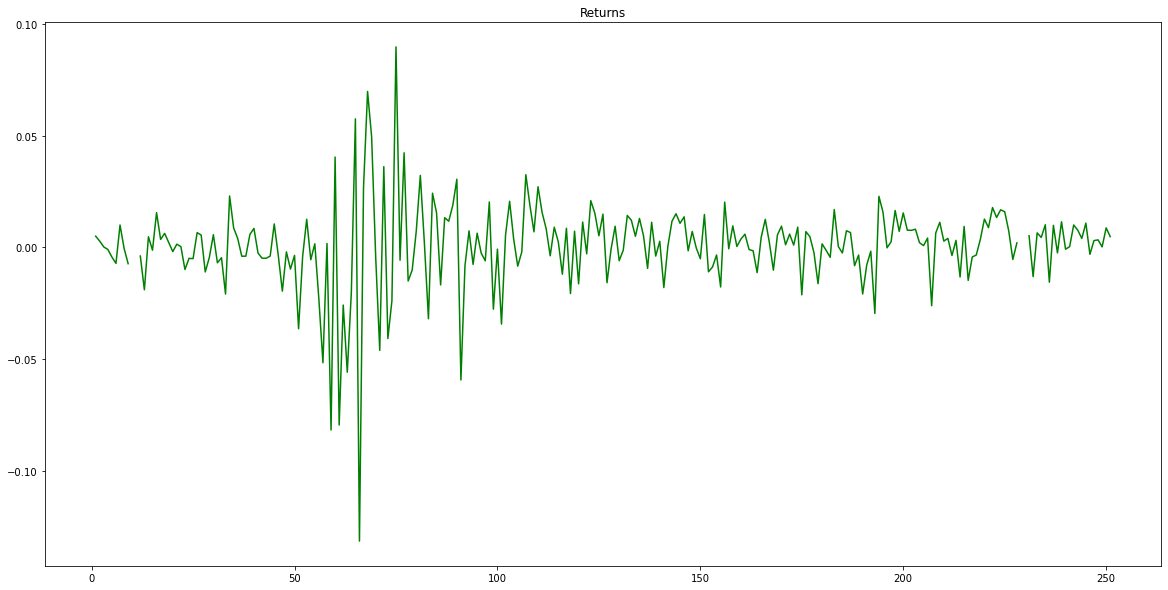

In [77]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [78]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

# Rolling mean and Standard Deviation


In [79]:
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)
 
 print('Results of dickey fuller test')



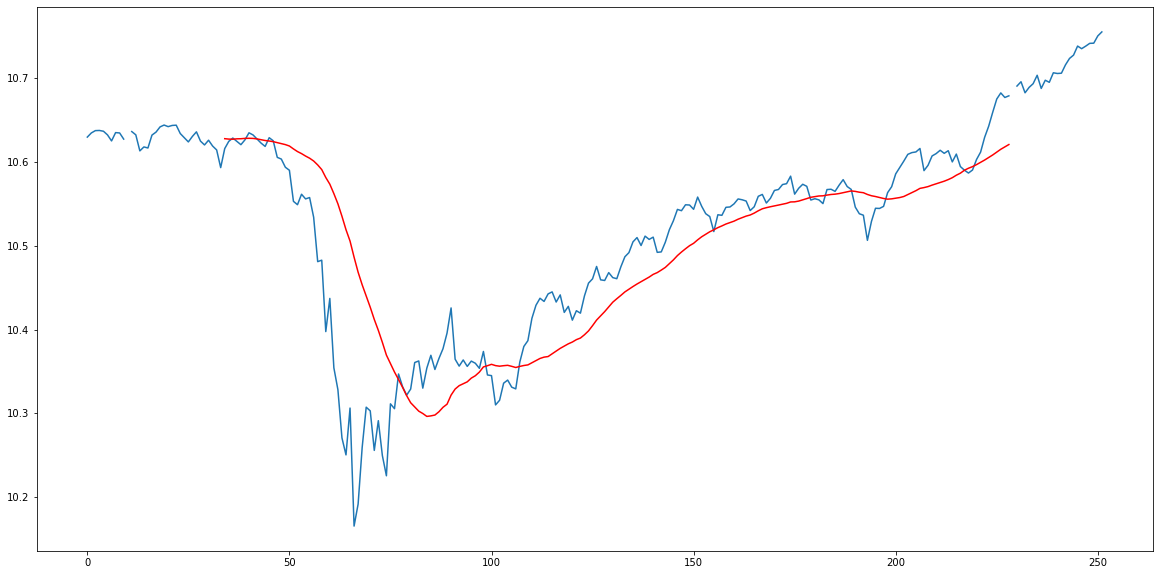

In [80]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

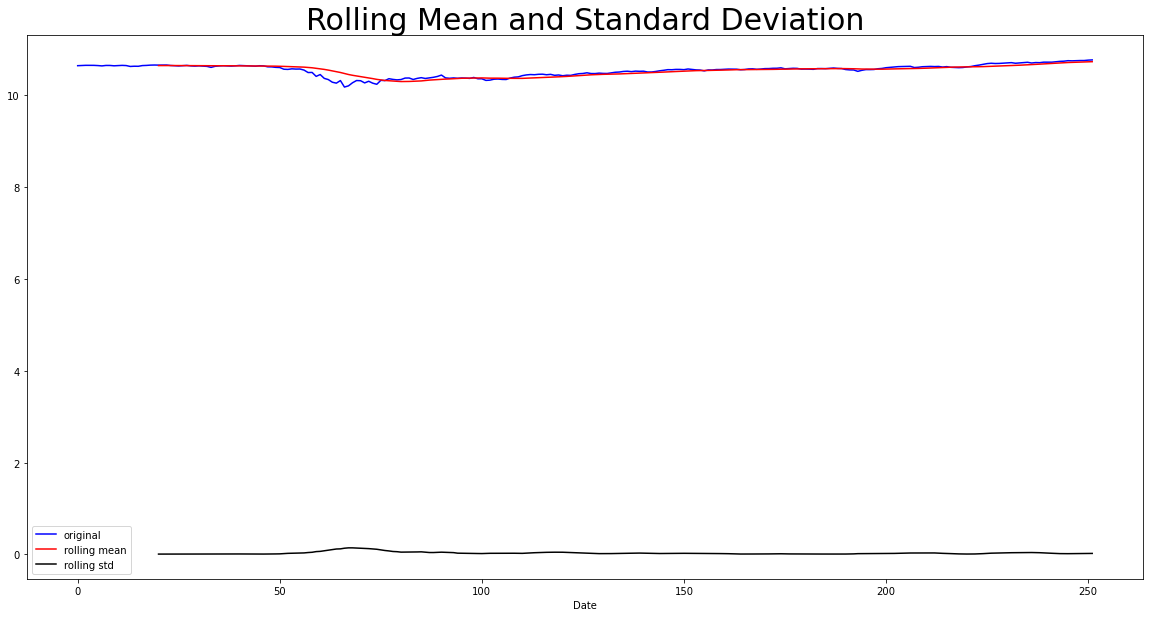

Results of dickey fuller test


In [81]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

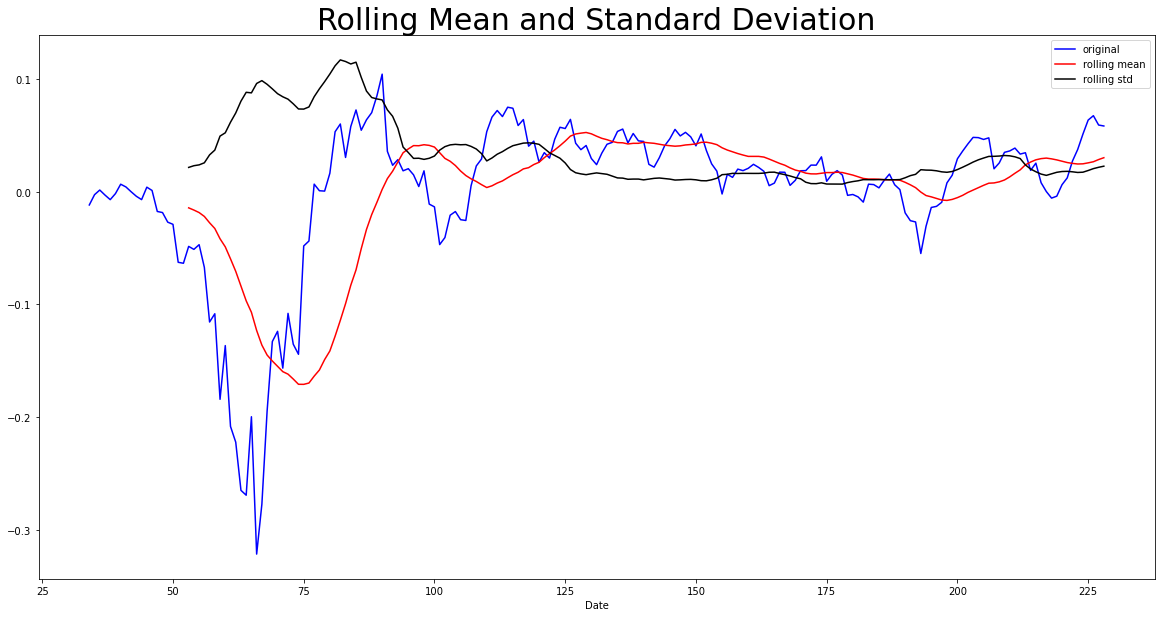

Results of dickey fuller test


In [82]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

# Textual Analysis



In [83]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity


#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
3627,2011-01-19,My ex doesn't want me Pratik Saali is not a g...,0.357963,0.066948
3628,2011-01-20,Neetu Chandra denies going panty less Aishwar...,0.358613,0.047965
3629,2011-01-21,Giving the kids a dressing up AK Hangal's ill ...,0.398969,0.030309
3630,2011-01-22,DTE seeks report from tech institutes Corporat...,0.403038,0.062312


# Merge the Historical and Textual Data



In [85]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity


# Create Dataset for Model Training¶


In [88]:
dfmerge1 = hisdf[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

KeyError: "['Subjectivity', 'Neutral', 'Negative', 'Polarity', 'Compound', 'Positive'] not in index"

In [89]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

NameError: name 'X' is not defined

In [91]:

X=hisdf.drop('Close',axis=1)
X

,Date,Open,High,Low,Volume
0,2019-12-17,41052.35938,41401.64844,41005.17969,19000.0
1,2019-12-18,41442.75000,41614.76953,41358.46875,24300.0
2,2019-12-19,41571.82031,41719.28906,41456.39844,33300.0
3,2019-12-20,41746.19922,41809.96094,41636.10938,33600.0
4,2019-12-23,41548.26172,41701.62109,41474.60938,6200.0
...,...,...,...,...,...
247,2020-11-12,46060.32031,46309.62891,45706.21875,26300.0
248,2020-12-14,46284.69922,46373.33984,45951.53125,18400.0
249,2020-12-15,46287.39063,46350.30078,45841.67188,16400.0
250,2020-12-16,46573.30859,46704.96875,46402.19922,13100.0


In [92]:

Y=hisdf['Close']
Y

0      41352.17188
1      41558.57031
2      41673.92188
3      41681.53906
4      41642.66016
          ...     
247    46099.01172
248    46253.46094
249    46263.17188
250    46666.46094
251    46890.33984
Name: Close, Length: 252, dtype: float64

# Split the Dataset into Train & Test Data

In [93]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(201, 5)

In [94]:
x_train[:10]


,Date,Open,High,Low,Volume
162,2020-12-08,38321.12891,38414.37109,38125.80859,25300.0
159,2020-07-08,37951.07031,38109.67969,37787.37891,15300.0
76,2020-08-04,29701.91992,31227.97070,29602.93945,24700.0
59,2020-12-03,34472.50000,34472.50000,32493.09961,25200.0
176,2020-01-09,38754.00000,39226.82031,38542.10938,22000.0
229,2020-11-14,NaN,NaN,NaN,NaN
18,2020-01-13,41788.21094,41899.62891,41720.76172,10600.0
221,2020-04-11,40171.71094,40693.51172,40076.46875,20900.0
15,2020-08-01,40574.82813,40866.35938,40476.55078,18200.0
152,2020-07-29,38427.14844,38617.03125,37884.41016,17600.0


# - RandomForestRegressor Model¶


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

# - DecisionTreeRegressor Model¶


In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

# - AdaBoostRegressor Model¶


In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

# - LGBMRegressor Model¶


In [ ]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

# - XGBRegressor Model¶


In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

# Conclusion
I have successfully tried to create a hybrid model for stock price/performance prediction.
- RandomForest = 0.05257968397499098
- DecisionTree = 0.10831900809236311
- AdaBoost = 0.05492347045438241
- LightGBM = 0.0583079056070462
- XGBoost = 0.05968830860645931
From here we can see that RandomForestRegressor shows a better performance than the others
Thank You